In [1]:
from sklearn.datasets import fetch_openml

In [2]:
import tensorflow.keras.datasets as tfds

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tfds.fashion_mnist.load_data()

## Using basic ML first to observe the performance

In [4]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [5]:
print(x_train.shape)
print(x_train.max())
print(x_train.dtype)
print(y_train)

(60000, 28, 28)
255
uint8
[9 0 0 ... 3 0 5]


In [6]:
x_train_scale = x_train/255.0
print(x_train_scale.shape)
print(x_train_scale.mean())
print(x_train_scale.dtype)

(60000, 28, 28)
0.2860405969887955
float64


In [11]:
pca = PCA(0.95)

In [12]:
x_train_scale_vec = x_train_scale.reshape(x_train.shape[0], -1)
x_train_scale_pca = pca.fit_transform(x_train_scale_vec)

In [13]:
print(x_train_scale_pca.shape)
print(x_train_scale_pca.mean())
print(x_train_scale_pca.dtype)

(60000, 187)
-4.2613138211185833e-16
float64


In [14]:
models = {}
models['svc'] = SVC()
models['forest'] = RandomForestClassifier()

In [15]:
models['svc'].fit(x_train_scale_pca, y_train)

SVC()

In [16]:
x_test_scale = x_test/255.0
x_test_scale_vec = x_test_scale.reshape(x_test.shape[0], -1)
x_test_scale_pca = pca.transform(x_test_scale_vec)

In [17]:
models['svc'].score(x_test_scale_pca, y_test)

0.886

In [19]:
models['svc'].n_support_.sum()

19959

**Let's try on RandomForest**

In [20]:
models['forest'].fit(x_train_scale_pca, y_train)

RandomForestClassifier()

In [21]:
models['forest'].score(x_test_scale_pca, y_test)

0.8579

In [25]:
import os
import pickle
from shutil import copyfileobj

SAVE_PATH = './saved_model/ch10-deeplearning'
os.makedirs(SAVE_PATH)

with open(SAVE_PATH + '/basic-ml-models', 'wb') as f:
    serial = pickle.dumps(models)
    f.write(serial)

**We can see that the basic-ml model cannot reach 90% in this task (note that we reduce the dimension of the data making it loss the information about 5%)**

## Test on deep learning model !

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

In [45]:
tf.keras.backend.clear_session()

dnn = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(150, activation='relu'),
    Dense(150, activation='relu'),
    Dense(10, activation = 'softmax')
])

dnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [46]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
Total params: 141,910
Trainable params: 141,910
Non-trainable params: 0
_________________________________________________________________


In [47]:
dnn.fit(x_train_scale, y_train, epochs = 20, validation_data=(x_test_scale, y_test))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4800 - accuracy: 0.8283 - val_loss: 0.4333 - val_accuracy: 0.8422
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3609 - accuracy: 0.8683 - val_loss: 0.3712 - val_accuracy: 0.8625
Epoch 3/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3281 - accuracy: 0.8795 - val_loss: 0.3542 - val_accuracy: 0.8706
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3053 - accuracy: 0.8868 - val_loss: 0.3369 - val_accuracy: 0.8774
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2855 - accuracy: 0.8935 - val_loss: 0.3416 - val_accuracy: 0.8759
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2721 - accuracy: 0.8978 - val_loss: 0.3355 - val_accuracy: 0.8806
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2594 - accuracy: 0.9035 - val_loss: 0.3287 - val_accuracy:

In [55]:
import numpy as np

print(np.argmax(dnn.predict(x_test_scale[:20]), axis = 1))
print(y_test[:20])

[9 2 1 1 6 1 4 6 5 7 4 5 5 3 4 1 2 2 8 0]
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0]


In [59]:
dnn.save(SAVE_PATH+'/plain-dnn')

INFO:tensorflow:Assets written to: ./saved_model/ch10-deeplearning/plain-dnn/assets


In [62]:
dnn.save(SAVE_PATH+'/plain-dnn-h5.h5')

## Question 3  
Logistics regression have a few hyper parameters to tweak and thus it is easier to implement in practice.  
Actually, it is a multilayer perceptron with one hidden layer and one neuron.

## Question 4  
Logistics regression always have a slop in any point of X, thus, it can be converged by gradient descent.  
In contrast, the step function doesn't contain the slop so the Gradient descent is not moved at all.

## Question 5 
1. Rectifier linear unit  
2. Sigmoid  
3. Hyperbolic tangent (tanh)  
4. Leaky Relu

## Question 6  
* X shape is (m, 10). --> m is number of samples and n is the number of features. 
* W1 shape is (50, 10), b1 shape is (1, 50).  
* Wo shape is (3, 50), bo shape is (1, 3).  
* Y shape is (m, 3).  
* Y = activation(activation(X\*W1' + b1)\*Wo + bo))

## Question 7. 
1. For email spam classification, we need only one neuron with sigmoid or tahnh function.  
2. For multilabel application like MNIST, we have to use number of output neurons equal to number of classes. Activation should be softmax).  
3. For regression task, we only need one output neuron without activation function.

## Question 8. 
In computation steps, reverse mode autodiff and backpropagation is the same. However, the concept of reverse mode autodiff is just to calculate gradient of each variable. While backpropagation is the whole process to update each parameter of neural network using Gradient Descent.

## Question 9. 
There are many hyperparameters for MLPs to be tuned, such as  
1. Number of layers  
2. Number of neurons in each layer 
3. Learning rate 
4. Regularization  
5. Type of activation function

## Question 10. 
Try tunig neural network to predict MNIST with accuracy of 98%!

In [132]:
from sklearn.datasets import fetch_openml
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential

In [64]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [65]:
X, y = fetch_openml('mnist_784', version = 1, return_X_y=True)

In [102]:
num_train = 60000

# transform data
y = y.astype(int)
X_scale = X/255

X_train, X_test = X_scale[:num_train], X_scale[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

In [106]:
## basic visualize input
print(X.shape)
print(X_train.min())
print(X_train.max())
print(y_train.min())
print(y_train.max())
print(X.dtype)

(70000, 784)
0.0
1.0
0
9
float64


In [107]:
def lr_scheduler(epoch, lr):
    return lr*tf.math.exp(epoch/100)

lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [137]:
def gen_logdir():
    import time
    import os
    ROOT_PATH = './saved_model/ch10-deeplearning/mnist-model-logs'
    log_dir = time.strftime("%Y%m%d-%H%M%S")
    return os.path.join(ROOT_PATH, log_dir)
    
run_logdir = gen_logdir()

In [155]:
FILE_PATH = './saved_model/ch10-deeplearning/mnist-best-model'

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10)
save_best_cb = tf.keras.callbacks.ModelCheckpoint(FILE_PATH, save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [162]:
model = Sequential([
    Input(shape = [784]),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'],
              optimizer=tf.keras.optimizers.SGD(lr = 0.2))

In [163]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 328,810
Trainable params: 328,810
Non-trainable params: 0
_________________________________________________________________


In [164]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

history = model.fit(X_train, y_train, 
#           callbacks=[early_stop_cb, save_best_cb, tensorboard_cb],
          callbacks=[early_stop_cb, save_best_cb],
#           callbacks=[lr_scheduler_cb],
          validation_data=(X_test, y_test),
          epochs = 100
         )

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4014 - accuracy: 0.8752 - val_loss: 0.1569 - val_accuracy: 0.9536
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2304 - accuracy: 0.9324 - val_loss: 0.1342 - val_accuracy: 0.9621
Epoch 3/100
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1935 - accuracy: 0.9434 - val_loss: 0.0953 - val_accuracy: 0.9701
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1724 - accuracy: 0.9491 - val_loss: 0.0946 - val_accuracy: 0.9707
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1551 - accuracy: 0.9543 - val_loss: 0.0896 - val_accuracy: 0.9738
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1443 - accuracy: 0.9563 - val_loss: 0.0852 - val_accuracy: 0.9742
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1350 - accuracy: 0.9591 - val_loss: 0.0803 - val_ac

In [165]:
print(history.history)
loss = history.history['loss']
val_loss = history.history['val_loss']

{'loss': [0.40137532353401184, 0.2303951531648636, 0.19345027208328247, 0.17240841686725616, 0.1551145613193512, 0.14427174627780914, 0.1349986046552658, 0.12945738434791565, 0.12508785724639893, 0.11730117350816727, 0.11375059932470322, 0.10969629883766174, 0.1040952205657959, 0.10474538803100586, 0.10042848438024521, 0.09941424429416656, 0.10008126497268677, 0.09384740889072418, 0.0881938636302948, 0.08812443166971207, 0.08816169947385788, 0.084639772772789, 0.08755512535572052, 0.08341549336910248, 0.0845818817615509, 0.08410821110010147, 0.07689609378576279, 0.08004670590162277, 0.07727761566638947, 0.0794922262430191, 0.07310046255588531, 0.07384046912193298, 0.07387550175189972, 0.0726594552397728, 0.07373599708080292, 0.07114942371845245, 0.07035522162914276], 'accuracy': [0.8751833438873291, 0.932449996471405, 0.9434000253677368, 0.9490666389465332, 0.9543166756629944, 0.9562833309173584, 0.9591166377067566, 0.9612666964530945, 0.962233304977417, 0.9655166864395142, 0.965466678

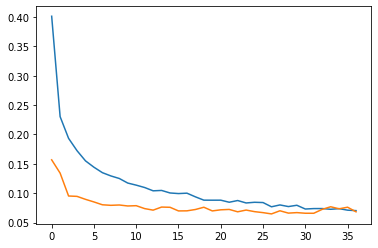

In [166]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.plot(val_loss)

In [94]:
# select minimum number
import numpy as np
print(lr[np.argmin(loss)])

0.0012336781


In [167]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0683 - accuracy: 0.9808: 0s - loss: 0.0871 - accura


[0.0683242455124855, 0.9807999730110168]

255.0
